In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()
# inspector = inspect(engine)

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# columns = inspector.get_columns('measurement')
# for c in columns:
#     print(c['name'], c["type"])

# columns = inspector.get_columns('station')
# for c in columns:
#     print(c['name'], c["type"])

In [8]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
import pandas as pd 

measurement_df = pd.DataFrame(session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all())
print(measurement_df)

station_df = pd.DataFrame(session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude,Station.elevation).all())
print(station_df)

          id      station        date  prcp  tobs
0          1  USC00519397  2010-01-01  0.08  65.0
1          2  USC00519397  2010-01-02  0.00  63.0
2          3  USC00519397  2010-01-03  0.00  74.0
3          4  USC00519397  2010-01-04  0.00  76.0
4          5  USC00519397  2010-01-06   NaN  73.0
...      ...          ...         ...   ...   ...
19545  19546  USC00516128  2017-08-19  0.09  71.0
19546  19547  USC00516128  2017-08-20   NaN  78.0
19547  19548  USC00516128  2017-08-21  0.56  76.0
19548  19549  USC00516128  2017-08-22  0.50  76.0
19549  19550  USC00516128  2017-08-23  0.45  76.0

[19550 rows x 5 columns]
   id      station                                    name  latitude  \
0   1  USC00519397                    WAIKIKI 717.2, HI US  21.27160   
1   2  USC00513117                    KANEOHE 838.1, HI US  21.42340   
2   3  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130   
3   4  USC00517948                       PEARL CITY, HI US  21.39340   
4   5  USC0051

In [11]:
# Find the most recent date in the data set.

most_recent_date = session.query(func.max(Measurement.date)).one()
most_recent_date = most_recent_date[0]
print(most_recent_date)

2017-08-23


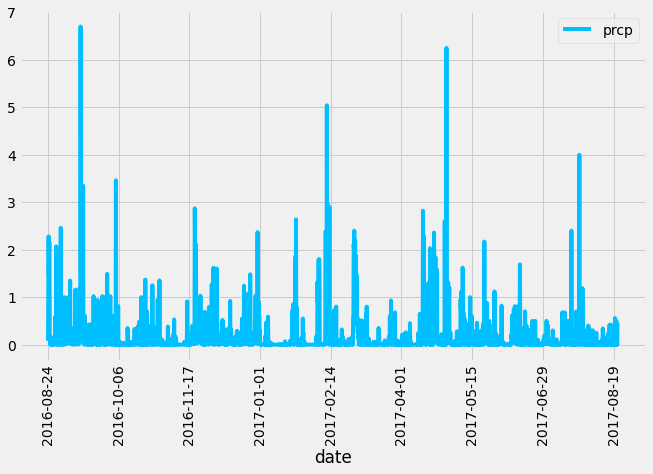

In [12]:
import datetime
from dateutil.relativedelta import relativedelta
from datetime import datetime
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 

most_recent_date

# Calculate the date one year from the last date in data set.
# last_year_date = datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

last_year_date = datetime.strptime(most_recent_date, "%Y-%m-%d") + relativedelta(years=-1)
last_year_date

# # Perform a query to retrieve the data and precipitation scores

data_between_dates = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date <= most_recent_date).\
    filter(Measurement.date >= last_year_date)

# # Save the query results as a Pandas DataFrame and set the index to the date column

data_between_dates_df = pd.DataFrame(data_between_dates).dropna()
data_between_dates_df.set_index('date', inplace=True)

# # Sort the dataframe by date

data_between_dates_df = data_between_dates_df.sort_values('date')
data_between_dates_df

# Use Pandas Plotting with Matplotlib to plot the data

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

data_between_dates_df.plot(rot=90,figsize=(10,6),color='deepskyblue')
plt.show()

# ax = data_between_dates_df.plot.bar(figsize=(12,7),width = 4, color='deepskyblue')
# plt.xticks(np.arange(0,len(data_between_dates_df),220))
# plt.tight_layout()
# plt.legend()
# plt.ylabel('Inches')
# ax.set_facecolor('whitesmoke')
# plt.show()
# ax.grid()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

data_between_dates_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset

session.query(Station).count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

from sqlalchemy import desc

station_list = session.query(Measurement.station,func.count(Measurement.station).label('station count')).\
                group_by(Measurement.station).\
                order_by(desc('station count')).all()
station_list

station_list_df = pd.DataFrame(station_list, columns=['station', 'count'])

station_list_df

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = station_list[0][0]
print(f'Most Active Station Id: {most_active_station_id}')

temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active_station_id).all()

print(f'Lowest temp. for {most_active_station_id}: {temp_stats[0][0]}')
print(f'Highest temp. for {most_active_station_id}: {temp_stats[0][1]}')
print(f'Average temp. for {most_active_station_id}: {round(temp_stats[0][2],1)}')


Most Active Station Id: USC00519281
Lowest temp. for USC00519281: 54.0
Highest temp. for USC00519281: 85.0
Average temp. for USC00519281: 71.7


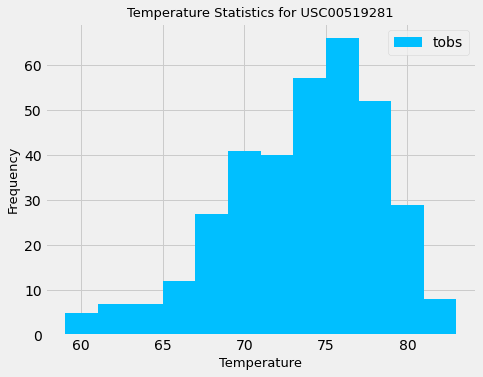

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_observation_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date <= most_recent_date).\
    filter(Measurement.date >= last_year_date).order_by(Measurement.date)

temp_observation_data_df = pd.DataFrame(temp_observation_data)
temp_observation_data_df

temp_observation_data_df.plot.hist(bins=12, figsize=(7,5),color='deepskyblue')
plt.tight_layout()
plt.legend()
plt.ylabel('Frequency',fontsize="13")
plt.xlabel('Temperature',fontsize="13")
plt.title(f'Temperature Statistics for {most_active_station_id}',fontsize="13")
# ax.set_facecolor('whitesmoke')
# plt.grid()
plt.show()


# Close session

In [18]:
# Close Session
session.close()